## Libraries Import

In [1]:
import sys

try:
    from library.synthetic_control import SyntheticControl
except ModuleNotFoundError:
    sys.path.append('/home/jupyter/datasphere')
    from library.synthetic_control import SyntheticControl

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import warnings
import pymc as pm
import arviz as az
import causalpy 
from patsy import build_design_matrices, dmatrices

from library.synthetic_control import *
from library.data_generator import generate_gaussian_process_data
from library.synthetic_did import SyntheticDIDModel
from library.synthetic_bayes import WeightedSumFitter


plt.style.use('ggplot')
warnings.filterwarnings("ignore")

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


## Data generation

In [3]:
N = 10     
T = 100     
T0 = 50       
effect = -20.0 
seed = 42

all_series = generate_gaussian_process_data(N=N, T=T, length_scale=2.0, seed=seed)

all_series[0, :] = all_series[0, :] * 10 + 60

all_series[0, T0:] += effect

np.random.seed(seed)
for i in range(1, N):
    baseline = np.random.uniform(40, 90)
    all_series[i, :] = all_series[i, :] * 10 + baseline
    
df_list = []
for unit_idx in range(N):
    for time_idx in range(T):
        y_val = all_series[unit_idx, time_idx]
        treated_flag = (unit_idx == 0) 
        after_treatment_flag = (time_idx >= T0)
        df_list.append({
            "unit": unit_idx,
            "time": time_idx,
            "y": y_val,
            "treated": treated_flag,
            "after_treatment": after_treatment_flag
        })

data = pd.DataFrame(df_list)

data_bayes = data.pivot(index='time', columns='unit', values='y').reset_index(drop=True).rename_axis(None, axis=1)
data_bayes = data_bayes.rename(columns={0:'actual', 1:'a', 2:'b', 3:'c', 4:'d', 5:'e', 6:'f', 7:'g', 8:'h', 9:'i'})

## Frequentist approach

### Synthetic control example

Реализуем следующую модель с добавлением константы:

$$
\min_{\mathbf{w} \in \Delta_J, \alpha} \left\| \mathbf{y}_{\text{pre}}^{\text{tr}} - \alpha - \mathbf{Y}_{\text{pre}}^{\text{co}} \mathbf{w} \right\|_2^2
$$
где $\Delta_J$ обозначает $J$-мерное симплексное множество и оно удовлетворяет условию:

$$\Delta_J = \left\{ \mathbf{w} \in \mathbb{R}^{J} \,\bigg|\, w_j \ge 0, \; \sum_{j=1}^{J} w_j = 1 \right\}
$$

А $\alpha$ представляет собой константу (интерцепт), которая позволяет учитывать постоянное смещение между целевой единицей и контрольными единицами.

Код основан на статье: https://matheusfacure.github.io/python-causality-handbook/25-Synthetic-Diff-in-Diff.html#synthetic-controls-revisited

Оценка ATT: -18.8496
Оценка стандартной ошибки: 0.9745
95% доверительный интервал: [-20.7595; -16.9397]
Веса синтетического контроля:
Индекс: 1, Значение: 0.04
Индекс: 2, Значение: 0.25
Индекс: 4, Значение: 0.05
Индекс: 5, Значение: 0.28
Индекс: 6, Значение: 0.31
Индекс: 7, Значение: 0.08
Индекс: 8, Значение: 0.0


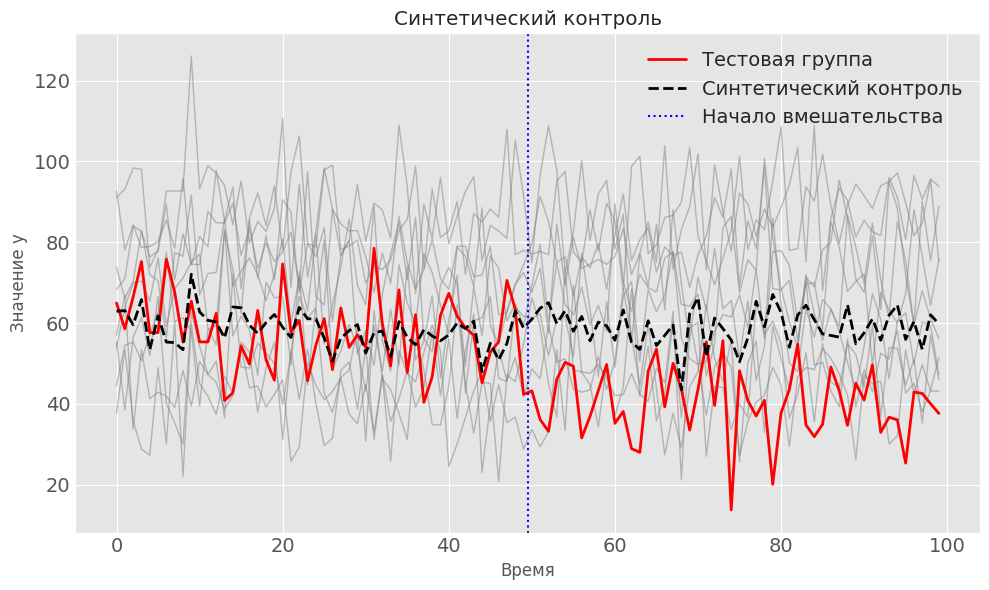

In [4]:
sc_model = SyntheticControl(
    data=data,
    metric="y",
    period_index="time",
    shopno="unit",
    treated="treated",
    after_treatment="after_treatment",
    bootstrap_rounds=100,
    seed=42,
    intercept=False
)
att_effect = sc_model.synthetic_control()
print("Оценка ATT:", round(att_effect, 4))

se, ci_low, ci_high = sc_model.estimate_se_sc(alpha=0.05)
print(f"Оценка стандартной ошибки: {round(se, 4)}")
print(f"95% доверительный интервал: [{round(ci_low, 4)}; {round(ci_high, 4)}]")

sc_model.plot_synthetic_control(T0=50)

In [6]:
y_co_pre = (
    data.query("treated == False and after_treatment == False")
        .pivot(index="time", columns="unit", values="y")
)

y_tr_pre = (
    data.query("treated == True and after_treatment == False")
        .sort_values("time")["y"]
)


sc_weights = pd.Series(sc_model.w_, index=y_co_pre.columns, name="weights")

y_co_all = (
    data.query("treated == False")
        .pivot(index="time", columns="unit", values="y")
        .sort_index()
)

sc_full = sc_model.a_ + y_co_all.dot(sc_weights) 

y_tr_all = (
    data.query("treated == True")
        .sort_values("time")["y"]
    .reset_index(drop=True) 
)

att = y_tr_all[T0:].mean() - sc_full[T0:].mean()
print("SC ATT:", round(att, 4))

print("Веса синтетического контроля:")
sc_weights_reset = sc_weights.reset_index().rename(columns={'index': 'unit'})
for i in range(len(sc_weights_reset)):
    value = sc_weights_reset.loc[i, 'weights']
    if value > 0:
        print(f"Индекс: {sc_weights_reset.loc[i, 'unit']}, Значение: {round(value, 2)}")

fig, ax = plt.subplots(figsize=(10, 6))

controls_all = data.query("treated == False")
for unit_idx in controls_all["unit"].unique():
    subset = controls_all.query("unit == @unit_idx").sort_values("time")
    ax.plot(subset["time"], subset["y"], color="gray", alpha=0.5, linewidth=1)

treated_all = data.query("treated == True").sort_values("time")
ax.plot(treated_all["time"], treated_all["y"], color="red", label="Тестовая группа", linewidth=2)

ax.plot(sc_full.index, sc_full.values, color="black", linestyle="--",
        label="Синтетический контроль", linewidth=2)

ax.axvline(T0 - 0.5, color='blue', linestyle=':', label='Начало вмешательства')

ax.set_xlabel("Время")
ax.set_ylabel("Значение показателя (y)")
ax.set_title("Синтетический контроль")
ax.legend()
plt.tight_layout()
plt.show()

AttributeError: 'SyntheticControl' object has no attribute 'a_'

### Synthetic DIFF and DIFF example

$$
\hat{w}^{sdid} = \underset{w}{\mathrm{argmin}} \; \left\{ \Bigl\|\bar{{y}}_{pre,tr} - \bigl({Y}_{pre,co} \, {w}_{co} + w_0\bigr)\Bigr\|_2^2 + \zeta^2\, T_{pre}\, \Bigl\|{w}_{co}\Bigr\|_2^2 \right\}
$$

при условии, что $(\sum_i w_i = 1)$ и $(w_i > 0)$ для всех $i$, а также

$$
\zeta = \bigl(N_{tr} \, T_{post}\bigr)^{1/4} \, \sigma(\Delta_{it})
$$

Код основан на статье: https://matheusfacure.github.io/python-causality-handbook/25-Synthetic-Diff-in-Diff.html#synthetic-controls-revisited

In [11]:
import numpy as np
import pandas as pd
import cvxpy as cp
import statsmodels.formula.api as smf
from joblib import Parallel, delayed
from scipy.stats import norm


class SyntheticDIDModel:
    def __init__(self, data, metric, period_index, shopno, treated, after_treatment,
                 seed=42, bootstrap_rounds=100, njobs=4):
        self.data = data.copy()
        self.outcome_col = metric
        self.period_index_col = period_index
        self.shopno_col = shopno
        self.treat_col = treated
        self.post_col = after_treatment
        self.seed = seed
        self.bootstrap_rounds = bootstrap_rounds
        self.njobs = njobs

    def calculate_regularization(self, data):
        n_treated_post = data.query(f"{self.post_col}").query(f"{self.treat_col}").shape[0]
        first_diff_std = (data
                          .query(f"~{self.post_col}")
                          .query(f"~{self.treat_col}")
                          .sort_values(self.period_index_col)
                          .groupby(self.shopno_col)[self.outcome_col]
                          .diff()
                          .std())
        return n_treated_post ** (1 / 4) * first_diff_std

    def join_weights(self, data, unit_w, time_w):
        joined = (data
                  .set_index([self.period_index_col, self.shopno_col])
                  .join(time_w)
                  .join(unit_w)
                  .reset_index()
                  .fillna({
                      time_w.name: 1 / len(pd.unique(data.query(f"{self.post_col}")[self.period_index_col])),
                      unit_w.name: 1 / len(pd.unique(data.query(f"{self.treat_col}")[self.shopno_col]))
                  })
                  .assign(**{"weights": lambda d: (d[time_w.name] * d[unit_w.name]).round(10)})
                  .astype({self.treat_col: int, self.post_col: int}))
        return joined

    def fit_time_weights(self, data):
        control = data.query(f"~{self.treat_col}")
        y_pre = (control
                 .query(f"~{self.post_col}")
                 .pivot(index=self.period_index_col, columns=self.shopno_col, values=self.outcome_col))
        y_post_mean = (control
                       .query(f"{self.post_col}")
                       .groupby(self.shopno_col)[self.outcome_col]
                       .mean()
                       .values)
        X = np.concatenate([np.ones((1, y_pre.shape[1])), y_pre.values], axis=0)
        w = cp.Variable(X.shape[0])
        objective = cp.Minimize(cp.sum_squares(w @ X - y_post_mean))
        constraints = [cp.sum(w[1:]) == 1, w[1:] >= 0]
        problem = cp.Problem(objective, constraints)
        problem.solve(verbose=False)
        return pd.Series(w.value[1:], name="time_weights", index=y_pre.index)

    def fit_unit_weights(self, data):
        zeta = self.calculate_regularization(data)
        pre_data = data.query(f"~{self.post_col}")
        y_pre_control = (pre_data
                         .query(f"~{self.treat_col}")
                         .pivot(index=self.period_index_col, columns=self.shopno_col, values=self.outcome_col))
        y_pre_treat_mean = (pre_data
                            .query(f"{self.treat_col}")
                            .groupby(self.period_index_col)[self.outcome_col]
                            .mean())
        T_pre = y_pre_control.shape[0]
        X = np.concatenate([np.ones((T_pre, 1)), y_pre_control.values], axis=1)
        w = cp.Variable(X.shape[1])
        objective = cp.Minimize(cp.sum_squares(X @ w - y_pre_treat_mean.values) +
                                T_pre * zeta ** 2 * cp.sum_squares(w[1:]))
        constraints = [cp.sum(w[1:]) == 1, w[1:] >= 0]
        problem = cp.Problem(objective, constraints)
        problem.solve(verbose=False)
        return pd.Series(w.value[1:], name="unit_weights", index=y_pre_control.columns), w.value[0]

    def synthetic_diff_in_diff(self, data=None):
        if data is None:
            data = self.data
        unit_weights, intercept = self.fit_unit_weights(data)
        time_weights = self.fit_time_weights(data)
        did_data = self.join_weights(data, unit_weights, time_weights)
        formula = f"{self.outcome_col} ~ {self.post_col}*{self.treat_col}"
        did_model = smf.wls(formula, data=did_data, weights=did_data["weights"] + 1e-10).fit()
        att = did_model.params[f"{self.post_col}:{self.treat_col}"]
        return att, unit_weights, time_weights, did_model, intercept

    def make_random_placebo(self, data):
        np.random.seed()
        placebo_data = data.copy()
        control_units = placebo_data.query(f"~{self.treat_col}")[self.shopno_col].unique()
        placebo_unit = np.random.choice(control_units)
        placebo_data[self.treat_col] = (placebo_data[self.shopno_col] == placebo_unit).astype(int)
        return placebo_data

    def estimate_se(self, alpha=0.05):
        np.random.seed(self.seed)
        main_att, *_ = self.synthetic_diff_in_diff()
        effects = Parallel(n_jobs=self.njobs)(
            delayed(lambda: self.synthetic_diff_in_diff(data=self.make_random_placebo(self.data))[0])()
            for _ in range(self.bootstrap_rounds)
        )
        se = np.std(effects, ddof=1)
        z = norm.ppf(1 - alpha / 2)
        ci_lower = main_att - z * se
        ci_upper = main_att + z * se
        return main_att, se, ci_lower, ci_upper


In [12]:
model = SyntheticDIDModel(
    data=data,
    metric="y",
    period_index="time",
    shopno="unit",
    treated="treated",
    after_treatment="after_treatment",
    bootstrap_rounds=100,
    seed=42,
    njobs=4
)

att, se, ci_low, ci_high = model.estimate_se(alpha=0.05)

print(f"Оценка ATT: {round(att, 4)}")
print(f"Стандартная ошибка: {round(se, 4)}")
print(f"95% доверительный интервал: [{round(ci_low, 4)}; {round(ci_high, 4)}]")


KeyError: "None of [Index([0, 0, 0, 0, 0, 0, 0, 0, 0, 0,\n       ...\n       0, 0, 0, 0, 0, 0, 0, 0, 0, 0],\n      dtype='int64', length=500)] are in the [index]"

In [ ]:
    data=data,
    metric="y",
    period_index="time",
    shopno="unit",
    treated="treated",
    after_treatment="after_treatment",
    bootstrap_rounds=100,
    seed=42,
    intercept=False

In [ ]:
sc_did = y_co_all.dot(sc_weights) 
sdid_model = SyntheticDIDModel(
    data=data,
    outcome_col="y",
    period_index_col="time",
    shopno_col="unit",
    treat_col="treated",
    post_col="after_treatment"
)

att, unit_weights, time_weights, sdid_model_fit, intercept = sdid_model.synthetic_diff_in_diff()

print("SDID ATT:", round(att, 4))

print("Веса синтетического контроля:")
unit_weights_reset = unit_weights.reset_index()
for i in range(len(sc_weights_reset)):
    value = unit_weights_reset['unit_weights'][i]
    if value > 0:
        print(f"Индекс: {unit_weights_reset['unit'][i]}, Значение: {round(value, 2)}")

avg_pre_period = (time_weights * time_weights.index).sum()
avg_post_period = T0 + (data.time.max() - T0) / 2

pre_sc = sdid_model_fit.params["Intercept"]
post_sc = pre_sc + sdid_model_fit.params["after_treatment"]
pre_treat = pre_sc + sdid_model_fit.params["treated"]
post_treat = post_sc + sdid_model_fit.params["treated"] + sdid_model_fit.params["after_treatment:treated"]
sc_did_y0 = pre_treat + (post_sc - pre_sc)

plt.style.use('ggplot')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,8), sharex=True,
                                gridspec_kw={'height_ratios': [3, 1]})

controls_all = data.query("treated == False")
for unit_idx in controls_all["unit"].unique():
    subset = controls_all.query("unit == @unit_idx").sort_values("time")
    ax1.plot(subset["time"], subset["y"], color="gray", alpha=0.5, linewidth=1)

ax1.plot(sc_did.index, sc_did, label="Synthetic", color="black", alpha=0.8)
ax1.plot(treated_all["time"], treated_all["y"], label="Тестовая группа", color="red")

ax1.plot([avg_pre_period, avg_post_period], [pre_sc, post_sc],
         color="C5", label='Контрфактический тренд')
ax1.plot([avg_pre_period, avg_post_period], [pre_treat, post_treat],
         color="C2", ls="dashed", label='effect')
ax1.plot([avg_pre_period, avg_post_period], [pre_treat, sc_did_y0],
         color="C2", label='Синтетический тренд')


x_bracket = avg_post_period
y_top = post_treat      
y_bottom = sc_did_y0

ax1.annotate(
    '', 
    xy=(x_bracket, y_bottom), 
    xytext=(x_bracket, y_top),
    arrowprops=dict(arrowstyle='|-|', color='purple', lw=2)
)

ax1.text(x_bracket + 0.5, (y_top + y_bottom) / 2, f"ATT = {round(att,2)}",
         color='purple', fontsize=12, va='center')

ax1.legend()
ax1.set_title("Synthetic Diff-in-Diff")
ax1.axvline(T0, color='black', linestyle=':')
ax1.set_ylabel("Значение показателя (y)")

ax2.bar(time_weights.index, time_weights)
ax2.vlines(T0, 0, 1, color="black", ls="dotted")
ax2.set_ylabel("Веса для времени")
ax2.set_xlabel("Время")

plt.show()


SDID ATT: -17.18
Веса синтетического контроля:


NameError: name 'sc_weights_reset' is not defined

### Placebo variance estimation and comparison example

$$
\hat{V}^{placebo}_{\tau} = B^{-1}\sum_{b=1}^B\bigg(\hat{\tau}^{(b)} - \bar{\hat{\tau}}^{(b)}\bigg)^2
$$
 
$$
\tau \in \hat{\tau}^{sdid} \pm \mathcal{z}_{\alpha/2} \sqrt{\hat{V}_{\tau}}
$$
 
Код основан на статье: https://matheusfacure.github.io/python-causality-handbook/25-Synthetic-Diff-in-Diff.html#synthetic-controls-revisited

## Bayesian approach

### Bayesian Synthetic Control example

$$y_i \sim \mathcal{N}(\mu_i, \sigma^2)$$

$$\mu_i = \alpha + \sum_{j=2}^{J + 1} w_j \cdot X_{ij}$$

С априорными распределениями:

$$\alpha \sim \mathcal{N}(0, 1)$$
$$\mathbf{w_J} \sim \text{Dirichlet}(\mathbf{1})$$
$$\sigma \sim \text{HalfNormal}(1)$$

Поскольку веса сгенерированы из распределения Дирихле, эти значения автоматически удовлетворяют следующим условиям:


$$w_j \geq 0, \quad \sum_{j=1}^{J} w_j = 1$$

Код основан на статье: https://causalpy.readthedocs.io/en/stable/notebooks/sc_pymc.html

-----

Примечание: 

В библиотеке *causalpy* при реализации модели синтетического контроля с *"WeightedSumFitter"* возникает ошибка с тем, что константа принимается за вес и ее значение модель пытается привести к ограничениям о том, что она обязана быть неотрицательной и в сумме с весами давать 1, чего не должно происходить. Ниже будет использоваться исправленный класс *"WeightedSumFitter"*

In [ ]:
\subsubsection{Постановка задачи синтетического контроля}

В рамках методологии синтетического контроля рассматривается ситуация, когда доступна информация о наблюдениях за \( J+1 \) единицами в течение \( T \) периодов. Пусть \( Y_{it} \) обозначает измеренный исход для единицы \( i \) в период \( t \), где \( i=1,\dots,J+1 \) и \( t=1,\dots,T \) \cite{abadie2010synthetic}. Предполагается, что исключительно первая единица подвергается вмешательству, начиная с периода \( T_0 + 1 \). Истинный эффект данного вмешательства для тритмент-единицы оценивается следующим образом:
\[
\tau_{1t} = Y_{1t}^{I} - Y_{1t}^{N}, \quad t > T_0,
\]
где \( Y_{1t}^{I} \) — наблюдаемый результат после воздействия, а \( Y_{1t}^{N} \) — гипотетический исход без влияния вмешательства, который непосредственно не наблюдается.

Для получения контрфактического результата \( Y_{1t}^{N} \) используется взвешенная комбинация исходов контрольных единиц (доноров):
\[
\hat{Y}_{1t}^{N} = \sum_{j=2}^{J+1} w_j Y_{jt}, \quad t = 1,\dots,T,
\]
где вектор весов \( \mathbf{w} = (w_2, w_3, \dots, w_{J+1})^\prime \) выбирается таким образом, чтобы минимизировать разницу между фактическими значениями первой единицы и взвешенными результатами доноров на пред-интервенционном интервале \( t \leq T_0 \) \cite{vives2023bayesian}. При этом необходимо, чтобы веса удовлетворяли условиям неотрицательности и нормированности:
\[
w_j \geq 0, \quad \sum_{j=2}^{J+1} w_j = 1.
\]

Оптимальный вектор \( \mathbf{w} \) определяется на основе наблюдений до момента воздействия. Формально постановка задачи выглядит следующим образом \cite{facure}:
\[
\min_{\mathbf{w} \in \Delta_J} \left\| \mathbf{y}_{\text{pre}}^{\text{tr}} - \mathbf{Y}_{\text{pre}}^{\text{co}} \mathbf{w} \right\|_2^2,
\]
где множество \( \Delta_J \) представляет собой \( J \)-мерный симплекс:
\[
\Delta_J = \left\{ \mathbf{w} \in \mathbb{R}^{J} \mid w_j \geq 0, \sum_{j=1}^{J} w_j = 1 \right\}.
\]

Получив оптимальные веса \( \hat{\mathbf{w}} \), становится возможным вычисление контрфактических результатов для тритмент-единицы, а значит, и оценка эффекта вмешательства:
\[
\hat{\tau}_{1t} = Y_{1t} - \hat{Y}_{1t}^{N} = Y_{1t} - \sum_{j=2}^{J+1} \hat{w}_j Y_{jt}, \quad t > T_0.
\]
Средний эффект вмешательства (Average Treatment Effect on the Treated, ATT) в пост-интервенционный период рассчитывается как:
\[
\text{ATT} = \frac{1}{T - T_0} \sum_{t=T_0+1}^{T} \hat{\tau}_{1t}.
\]

Применение метода синтетического контроля базируется на ряде важных предпосылок:

\textbf{Предположение 1 (Cross-sectional SUTVA).} Потенциальный исход единицы зависит только от её собственного статуса вмешательства:
\[
Y_{it}(\mathbf{W}) = Y_{it}(w_i), \quad \forall i, t.
\]
Данная предпосылка исключает наличие перекрёстного влияния между единицами, сокращая число возможных траекторий исходов. Это позволяет свести многообразие потенциальных исходов к относительно простым функциям воздействия.

\textbf{Предположение 2 (Отсутствие антиципации).} Для всех единиц и периодов, предшествующих вмешательству, потенциальный исход должен совпадать с исходом в состоянии контроля:
\[
Y_{it}(a_i) = Y_{it}(c), \quad t < a_i, \forall i,
\]
где \( a_i \) — период принятия воздействия, а \( c \) — состояние без вмешательства. Это исключает возможность влияния ожиданий будущих воздействий на текущие результаты.

Кроме упомянутых предпосылок, дополнительно значима следующая:

\textbf{Предположение 3 (Стабильность временных рядов доноров).} Предполагается, что единицы-доноры не испытывают структурных изменений в течение рассматриваемого временного интервала, обеспечивая тем самым надежность и точность синтетического контроля.

Несмотря на простоту реализации и интерпретации, исходная модель синтетического контроля обладает рядом ограничений. Одно из них связано с постоянством выбранных весов во времени, что может быть некорректным при изменении вкладов доноров. Кроме того, отсутствие регуляризации может привести к чрезмерному сосредоточению весов на ограниченном числе единиц. Для устранения данных недостатков была предложена модифицированная версия подхода, получившая название «синтетический difference-in-differences», подробное обсуждение которой приводится далее.



#### Пример реализации на основе causalpy с исправленным *"WeightedSumFitter"*:

In [8]:
result_with_intercept = causalpy.SyntheticControl(
    data_bayes,
    treatment_time = T0,
    formula="actual ~ 1 + a + b + c + d + e + f + g + h + i",
    model=WeightedSumFitter(
        sample_kwargs={"target_accept": 0.95, "random_seed": seed}
    ),
)

az.summary(result_with_intercept.post_impact.mean("obs_ind"))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.
Sampling: [beta, intercept, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,-4.844,0.203,-5.244,-4.474,0.003,0.002,3594.0,3334.0,1.0


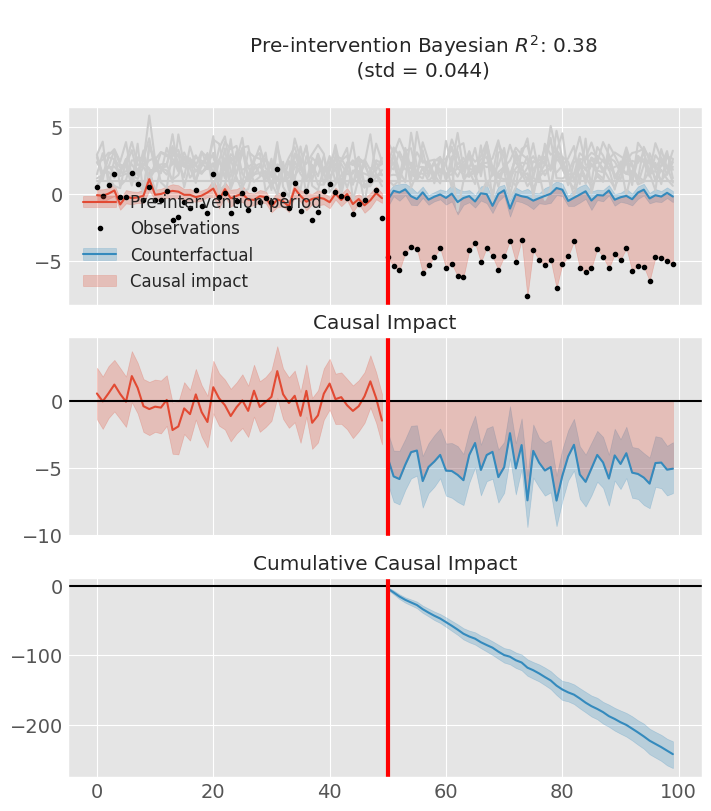

In [9]:
fig, ax = result_with_intercept.plot(plot_predictors=True)

In [10]:
result_with_intercept.print_coefficients()

Model coefficients:
    Intercept  -2.2, 94% HDI [-2.5, -1.9]
    a          0.061, 94% HDI [0.002, 0.19]
    b          0.26, 94% HDI [0.058, 0.47]
    c          0.069, 94% HDI [0.0027, 0.22]
    d          0.091, 94% HDI [0.0045, 0.25]
    e          0.11, 94% HDI [0.0073, 0.28]
    f          0.12, 94% HDI [0.0081, 0.31]
    g          0.06, 94% HDI [0.0024, 0.19]
    h          0.13, 94% HDI [0.01, 0.32]
    i          0.091, 94% HDI [0.0038, 0.27]
    sigma      0.98, 94% HDI [0.81, 1.2]


#### Пример реализации с помощью чистого pymc: 

На основе статьи: https://juanitorduz.github.io/synthetic_control_pymc/

In [41]:
treatment_time = T0

formula = "actual ~ 1 + a + b + c + d + e + f + g + h + i"

datapre = data_bayes[data_bayes.index < treatment_time]
datapost = data_bayes[data_bayes.index >= treatment_time]

y, X = dmatrices(formula, datapre)

pre_y, pre_X = np.asarray(y), np.asarray(X)


(new_y, new_x) = build_design_matrices(
    [y.design_info, X.design_info], datapost
)
post_X = np.asarray(new_x)
post_y = np.asarray(new_y)

del y, X

### надо в модель добавить что X и Y pre

# with pm.Model() as model:
#     n_predictors = X.shape[1]
#     X = pm.Data("X", X, dims=["obs_ind", "coeffs"])
#     y = pm.Data("y", y[:, 0], dims="obs_ind")
#     intercept = pm.Normal("intercept", mu=0, sigma=1)
#     beta = pm.Dirichlet("beta", a=np.ones(n_predictors-1), dims="coeffs")
#     X_without_intercept = X[:, 1:]  
#     mu = pm.Deterministic("mu", intercept + pm.math.dot(X_without_intercept, beta), dims="obs_ind")
#     sigma = pm.HalfNormal("sigma", 1)
#     pm.Normal("y_hat", mu, sigma, observed=y, dims="obs_ind")


# ### Вероятно должно быть так:
# with pm.Model() as model:
#     # Определяем размерности
#     n_predictors = pre_X.shape[1]
    
#     # Данные - используем только MutableData
#     X = pm.MutableData(name="X", value=pre_X)
#     y = pm.MutableData(name="y", value=pre_y[:, 0])
    
#     # Параметры
#     intercept = pm.Normal("intercept", mu=0, sigma=1)
#     beta = pm.Dirichlet("beta", a=np.ones(n_predictors-1), dims="coeffs")
    
#     # Среднее
#     X_without_intercept = X[:, 1:]
#     mu = pm.Deterministic("mu", intercept + pm.math.dot(X_without_intercept, beta))
    
#     # Дисперсия
#     sigma = pm.HalfNormal("sigma", 1)
    
#     # Наблюдаемые данные
#     pm.Normal("y_hat", mu, sigma, observed=y)

# with model:
#     idata = pm.sample()
#     posterior_predictive_pre = pm.sample_posterior_predictive(trace=idata)

In [ ]:

with pm.Model() as model:
    # Определяем размерности
    n_predictors = pre_X.shape[1]
    
    # Данные - используем только MutableData
    X = pm.MutableData(name="X", value=pre_X)
    y = pm.MutableData(name="y", value=pre_y[:, 0])
    
    # Параметры
    intercept = pm.Normal("intercept", mu=0, sigma=1)
    beta = pm.Dirichlet("beta", a=np.ones(n_predictors-1))
    
    # Среднее
    X_without_intercept = X[:, 1:]
    mu = pm.Deterministic("mu", intercept + pm.math.dot(X_without_intercept, beta))
    
    # Дисперсия
    sigma = pm.HalfNormal("sigma", 1)
    
    # Наблюдаемые данные
    pm.Normal("y_hat", mu, sigma, observed=y)

with model:
    idata = pm.sample()
    posterior_predictive_pre = pm.sample_posterior_predictive(trace=idata)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.
Sampling: [y_hat]


Output()

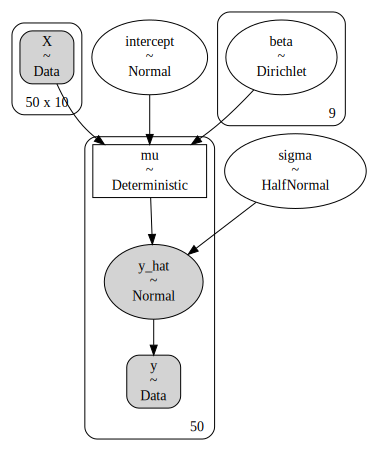

In [43]:
model.to_graphviz()

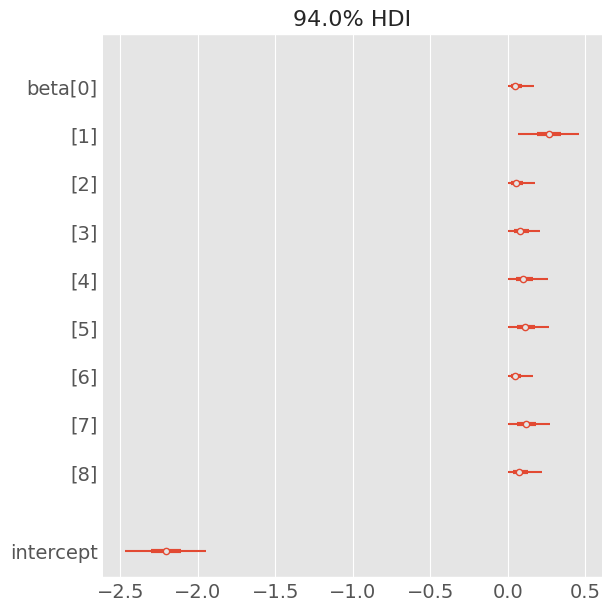

In [44]:
az.plot_forest(data=idata, combined=True, var_names=["beta", "intercept"]);

In [52]:
with model:
    pm.set_data(new_data={"X": post_X, "y": post_y[:, 0]})
    posterior_predictive_post = pm.sample_posterior_predictive(
        trace=idata, var_names=["y_hat"]
    )

Sampling: [y_hat]


Output()

In [66]:
import seaborn as sns


In [67]:
data_bayes

,actual,a,b,c,d,e,f,g,h,i
0,0.496714,0.584629,2.357787,1.171005,0.405572,2.926178,2.756989,1.477277,2.938284,2.368673
1,-0.138264,1.579355,2.560785,1.439819,1.400625,3.909417,1.077835,3.049009,1.483955,1.606661
2,0.647689,1.657285,3.083051,2.747294,2.005244,0.601432,2.869606,1.295656,2.096121,2.028745
3,1.523030,1.197723,3.053802,2.610370,2.046981,2.562969,3.355638,0.591539,1.537725,3.278452
4,-0.234153,1.838714,0.622331,1.979098,1.549935,1.349357,2.413435,0.443371,1.565504,2.191099
...,...,...,...,...,...,...,...,...,...,...
95,-6.463515,2.385317,1.307090,1.530824,2.538910,1.489984,1.690454,3.053153,2.648710,1.718900
96,-4.703880,1.116143,2.899600,0.286865,0.962754,1.730125,2.326133,1.960445,1.832882,3.797687
97,-4.738945,2.153725,2.307300,3.353872,1.809661,1.021236,0.748886,2.681501,2.146714,2.640843
98,-4.994887,2.058209,2.812862,1.885460,1.124382,1.555707,2.924027,2.028318,3.206509,1.428821


In [70]:
data_bayes_index = data_bayes.reset_index()

In [71]:
data_bayes_index.groupby(["index", "actual"], as_index=False)

In [72]:
posterior_predictive_pre.posterior_predictive

<xarray.Dataset> Size: 2MB
Dimensions:      (chain: 4, draw: 1000, y_hat_dim_2: 50)
Coordinates:
  * chain        (chain) int64 32B 0 1 2 3
  * draw         (draw) int64 8kB 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
  * y_hat_dim_2  (y_hat_dim_2) int64 400B 0 1 2 3 4 5 6 ... 43 44 45 46 47 48 49
Data variables:
    y_hat        (chain, draw, y_hat_dim_2) float64 2MB 1.156 ... -0.5822
Attributes:
    created_at:                 2025-04-09T17:43:49.676499+00:00
    arviz_version:              0.20.0
    inference_library:          pymc
    inference_library_version:  5.17.0

In [77]:
list(range(0, 50))

range(0, 50)

In [81]:
(
    data_bayes_index.groupby(["index"], as_index=False)
    .agg({"actual": np.mean})

SyntaxError: incomplete input (1164180824.py, line 3)

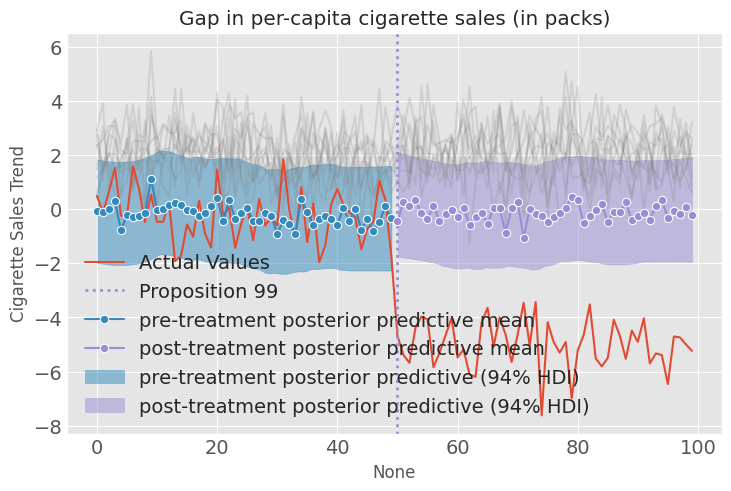

In [83]:
pre_posterior_mean = (
    posterior_predictive_pre.posterior_predictive["y_hat"][:, :, :T0]
    .stack(samples=("chain", "draw"))
    .mean(axis=1)
)

post_posterior_mean = (
    posterior_predictive_post.posterior_predictive["y_hat"][:, :, :T0]
    .stack(samples=("chain", "draw"))
    .mean(axis=1)
)


fig, ax = plt.subplots()

for col in data_bayes.columns:
    if col != 'actual':
        sns.lineplot(
            x=data_bayes.index,
            y=data_bayes[col],
            color='gray',
            alpha=0.2,
            ax=ax
        )

sns.lineplot(
    x=data_bayes.index,
    y=data_bayes['actual'],
    color='C0',
    label='Actual Values',
    ax=ax
)
ax.axvline(
    x=T0,
    linestyle=":",
    lw=2,
    color="C2",
    label="Proposition 99",
)
sns.lineplot(
    x=list(range(0, 50)),
    y=pre_posterior_mean,
    color="C1",
    marker="o",
    label="pre-treatment posterior predictive mean",
    ax=ax,
)
sns.lineplot(
    x=list(range(50, 100)),
    y=post_posterior_mean,
    color="C2",
    marker="o",
    label="post-treatment posterior predictive mean",
    ax=ax,
)
az.plot_hdi(
    x=list(range(0, 50)),
    y=posterior_predictive_pre.posterior_predictive["y_hat"][:, :, :T0],
    smooth=True,
    color="C1",
    fill_kwargs={"label": "pre-treatment posterior predictive (94% HDI)"},
    ax=ax,
)
az.plot_hdi(
    x=list(range(50, 100)),
    y=posterior_predictive_post.posterior_predictive["y_hat"][:, :, :T0],
    smooth=True,
    color="C2",
    fill_kwargs={"label": "post-treatment posterior predictive (94% HDI)"},
    ax=ax,
)
ax.legend(loc="lower left")
ax.set(
    title="Gap in per-capita cigarette sales (in packs)", ylabel="Cigarette Sales Trend"
);

добить для интереса: https://juanitorduz.github.io/synthetic_control_pymc/

### Bayesian R2D2 Synthetic Control example

ну может не R2D2 но гауссовский крутани процесс и какой-нить грязюки сделай

In [ ]:
treatment_time = T0

formula = "actual ~ 1 + a + b + c + d + e + f + g + h + i"

datapre = data_bayes[data_bayes.index < treatment_time]
datapost = data_bayes[data_bayes.index >= treatment_time]

y, X = dmatrices(formula, datapre)

pre_y, pre_X = np.asarray(y), np.asarray(X)


(new_y, new_x) = build_design_matrices(
    [y.design_info, X.design_info], datapost
)
post_X = np.asarray(new_x)
post_y = np.asarray(new_y)


with pm.Model() as model:
    n_predictors = X.shape[1]
    X = pm.Data("X", X, dims=["obs_ind", "coeffs"])
    y = pm.Data("y", y[:, 0], dims="obs_ind")
    intercept = pm.Normal("intercept", mu=0, sigma=1)
    beta = pm.Dirichlet("beta", a=np.ones(n_predictors-1), dims="coeffs")
    X_without_intercept = X[:, 1:]  
    mu = pm.Deterministic("mu", intercept + pm.math.dot(X_without_intercept, beta), dims="obs_ind")
    sigma = pm.HalfNormal("sigma", 1)
    pm.Normal("y_hat", mu, sigma, observed=y, dims="obs_ind")

with model:
    trace = pm.sample(return_inferencedata=True)

план кабан докрути байеса и подумай про предпосылки моделей и постарайся первую часть практи хотя бы добить с примерами и всем остальным

In [ ]:
with pm.Model() as model:
    # Определяем размерности
    n_predictors = pre_X.shape[1]
    
    # Данные - используем только MutableData
    X = pm.MutableData(name="X", value=pre_X)
    y = pm.MutableData(name="y", value=pre_y[:, 0])
    
    # Параметры линейной части
    intercept = pm.Normal("intercept", mu=0, sigma=1)
    beta = pm.Dirichlet("beta", a=np.ones(n_predictors-1))
    
    # Линейная часть модели
    X_without_intercept = X[:, 1:]
    linear_term = intercept + pm.math.dot(X_without_intercept, beta)
    
    # Гауссовский процесс
    # Определяем ядро (RBF)
    lengthscale = pm.HalfNormal("lengthscale", 1.0)
    kernel = pm.gp.cov.ExpQuad(input_dim=n_predictors-1, ls=lengthscale)
    
    # Создаем GP
    gp = pm.gp.Marginal(cov_func=kernel)
    
    # GP компонент
    f = gp.marginal_likelihood("f", X=X_without_intercept, y=y - linear_term, noise=pm.HalfNormal("noise", 1.0))
    
    # Комбинируем линейный компонент и GP
    mu = pm.Deterministic("mu", linear_term + f)
    
    # Дисперсия
    sigma = pm.HalfNormal("sigma", 1)
    
    # Наблюдаемые данные
    pm.Normal("y_hat", mu, sigma, observed=y)

with model:
    idata = pm.sample()
    posterior_predictive_pre = pm.sample_posterior_predictive(trace=idata)

ты ученый с 20 летним опытом в статистике ты пишешь связный текст без использования повторяющихся слов и не используешь во первых и во вторых а используешь академический язык. пишешь ответ на Latex. 

In [ ]:
import pymc as pm
import numpy as np
import arviz as az

# Пример исходных данных:
# y_obs: наблюдаемые данные (единицы × временные шаги)
# T: число временных шагов
# N: число контрольных единиц

# Предположим, у нас есть N контрольных единиц и 1 обрабатываемая единица
N = 5  # число контрольных единиц
T = 100  # число временных точек

# синтетические данные для примера
np.random.seed(42)
time = np.arange(T)
y_obs = np.random.normal(size=(N, T))

# Реализация модели
with pm.Model() as mtgp_model:
    # Гиперпараметры ядра
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
    σ_f = pm.HalfCauchy("σ_f", beta=1)
    σ_noise = pm.HalfCauchy("σ_noise", beta=1)
    
    # Ядро RBF для временной компоненты
    cov_time = σ_f ** 2 * pm.gp.cov.ExpQuad(1, ls=ℓ)
    
    # Определяем латентные функции (многозадачный GP)
    J = 2  # число латентных функций
    u_latent = []
    for j in range(J):
        gp_u = pm.gp.Latent(cov_func=cov_time)
        u = gp_u.prior(f'u_{j}', X=time.reshape(-1, 1))
        u_latent.append(u)

    # Веса единиц наблюдения для комбинации латентных функций
    β = pm.Normal("β", mu=0, sigma=1, shape=(N, J))

    # Средняя функция для каждой единицы
    f = pm.math.dot(β, pm.math.stack(u_latent))

    # Модель наблюдений с гауссовским шумом
    y = pm.Normal("y", mu=f, sigma=σ_noise, observed=y_obs)

    # Запускаем MCMC-сэмплирование
    trace = pm.sample(1000, tune=1000, chains=2, cores=2, target_accept=0.9)

# Визуализируем результаты
az.plot_trace(trace, var_names=["ℓ", "σ_f", "σ_noise"])
az.summary(trace, var_names=["ℓ", "σ_f", "σ_noise"])


В рамках исследования применены процедуры генерации данных, аналогичные используемым для анализа свойств оценивателей синтетических контролей, о чем свидетельствуют работы, проведённые, например, Firpo и Possebom (2018) и Abadie с Vives-i Bastida (2022). Потенциальное значение исхода при отсутствии интервенции определяется следующим образом:

\[
Y_{it}(0)= \lambda_{f(i)t} + \epsilon_{it},
\]

где компоненты \(\lambda_{f(i)t}\) подчиняются авторегрессионному процессу первого порядка с коэффициентом автокорреляции \(\rho = 0.5\) и стандартными гауссовскими инновациями, а случайные ошибки \(\epsilon_{it}\) распределены нормально: \(\epsilon_{it} \sim N(0, \sigma^2)\). Для упрощения модели считается, что обработке подвергается только единица с индексом 1, при этом эффект интервенции равен нулю.

При моделировании эксперимента рассматриваются два варианта распределения наблюдений по группам. В случае плотного дизайна наблюдения объединяются в две группы по 10 единиц, при условии, что для всех единиц в группе устанавливается общее значение параметра \(f(i)\). В результате оптимальный синтетический контроль для единицы, подвергшейся интервенции, формируется за счёт равномерного распределения весов по контрольным единицам (единицам с 2 по 10). Для разреженного дизайна единицы объединяются в 10 пар, где каждая пара характеризуется идентичным значением \(f(i)\). Такая организация приводит к тому, что оптимальный синтетический контроль закрепляет весь вес за одной из контрольных единиц (например, за единицей с индексом 2).

Ниже приводится описание трёх экспериментальных сценариев:

\begin{enumerate}
    \item Первая ситуация организована следующим образом. За наблюдательный период продолжительностью \(T=90\) дней рассматривается \(J=10\) точек. На контрольной точке с индексом \(j=1\) проводится интервенция в течение периода \(T_0=60\) дней. При этом величины эффекта принимают значения \(-5\%\), \(+5\%\), \(-10\%\), \(+10\%\), \(+15\%\) и \(-15\%\). До проведения интервенции на тестовой точке значение исследуемой метрики в среднем составляет около 60 минут, в то время как остальные точки демонстрируют уровень порядка 90 минут.
    
    \item Во второй ситуации экспериментальная конфигурация сохраняется: период наблюдения также равен \(T=90\) дням с \(J=10\) точками, на точке \(j=1\) осуществляется интервенция на \(T_0=60\) дней с аналогичными эффектами (\(-5\%\), \(+5\%\), \(-10\%\), \(+10\%\), \(+15\%\) и \(-15\%\)). Отличительной особенностью является то, что как тестовая, так и контрольные точки характеризуются средними значениями метрики около 60 минут.
    
    \item Третья ситуация направлена на оценку качества распределения весов, присваиваемых моделями синтетических контролей. При этом анализ проводится с использованием методологических подходов, описанных в работах \cite{abadie2022synthetic} и \cite{martinez2022bayesian}.
\end{enumerate}

Предложенные экспериментальные конструкции позволяют оценить чувствительность результатов к различным сценариям распределения наблюдений и эффектам интервенции, а также проверить корректность применения моделей синтетических контролей при оптимизации весовых коэффициентов.